In [7]:
import tensorflow as tf 
import os
import tarfile 
import pandas as pd
import xlrd
from functools import reduce
import numpy as np
import time
import cv2
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import random

from glob import glob
import re
import pydot
import scipy.misc

from tensorflow.keras import layers, Input
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import SVG
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import mean_absolute_error
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import Sequential
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from tensorflow.python.client import device_lib
from keras.applications.inception_v3 import preprocess_input

%matplotlib inline

ImportError: libGL.so.1: cannot open shared object file: No such file or directory

In [9]:
!apt install libgl1-mesa-glx
!RUN apt-get update ##[edited]
!RUN apt-get install ffmpeg libsm6 libxext6  -y




E: Unable to locate package libgl1-mesa-glx
/bin/bash: RUN: command not found
/bin/bash: RUN: command not found


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks')
from scripts.utilities import download_images, train_val_test_gen, myCustomGen, CreateCallbacks,MAE,get_predictions

## Download Images

In [ ]:
"""
Downloading the images in the Colab Machine:
"""
# download_images(train = True, val = True, test = True)

'\nDownloading the images in the Colab Machine:\n'

In [ ]:
"""
Importing the datasets containing the images IDs with boneages
"""
train_df, val_df, test_df = train_val_test_gen()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


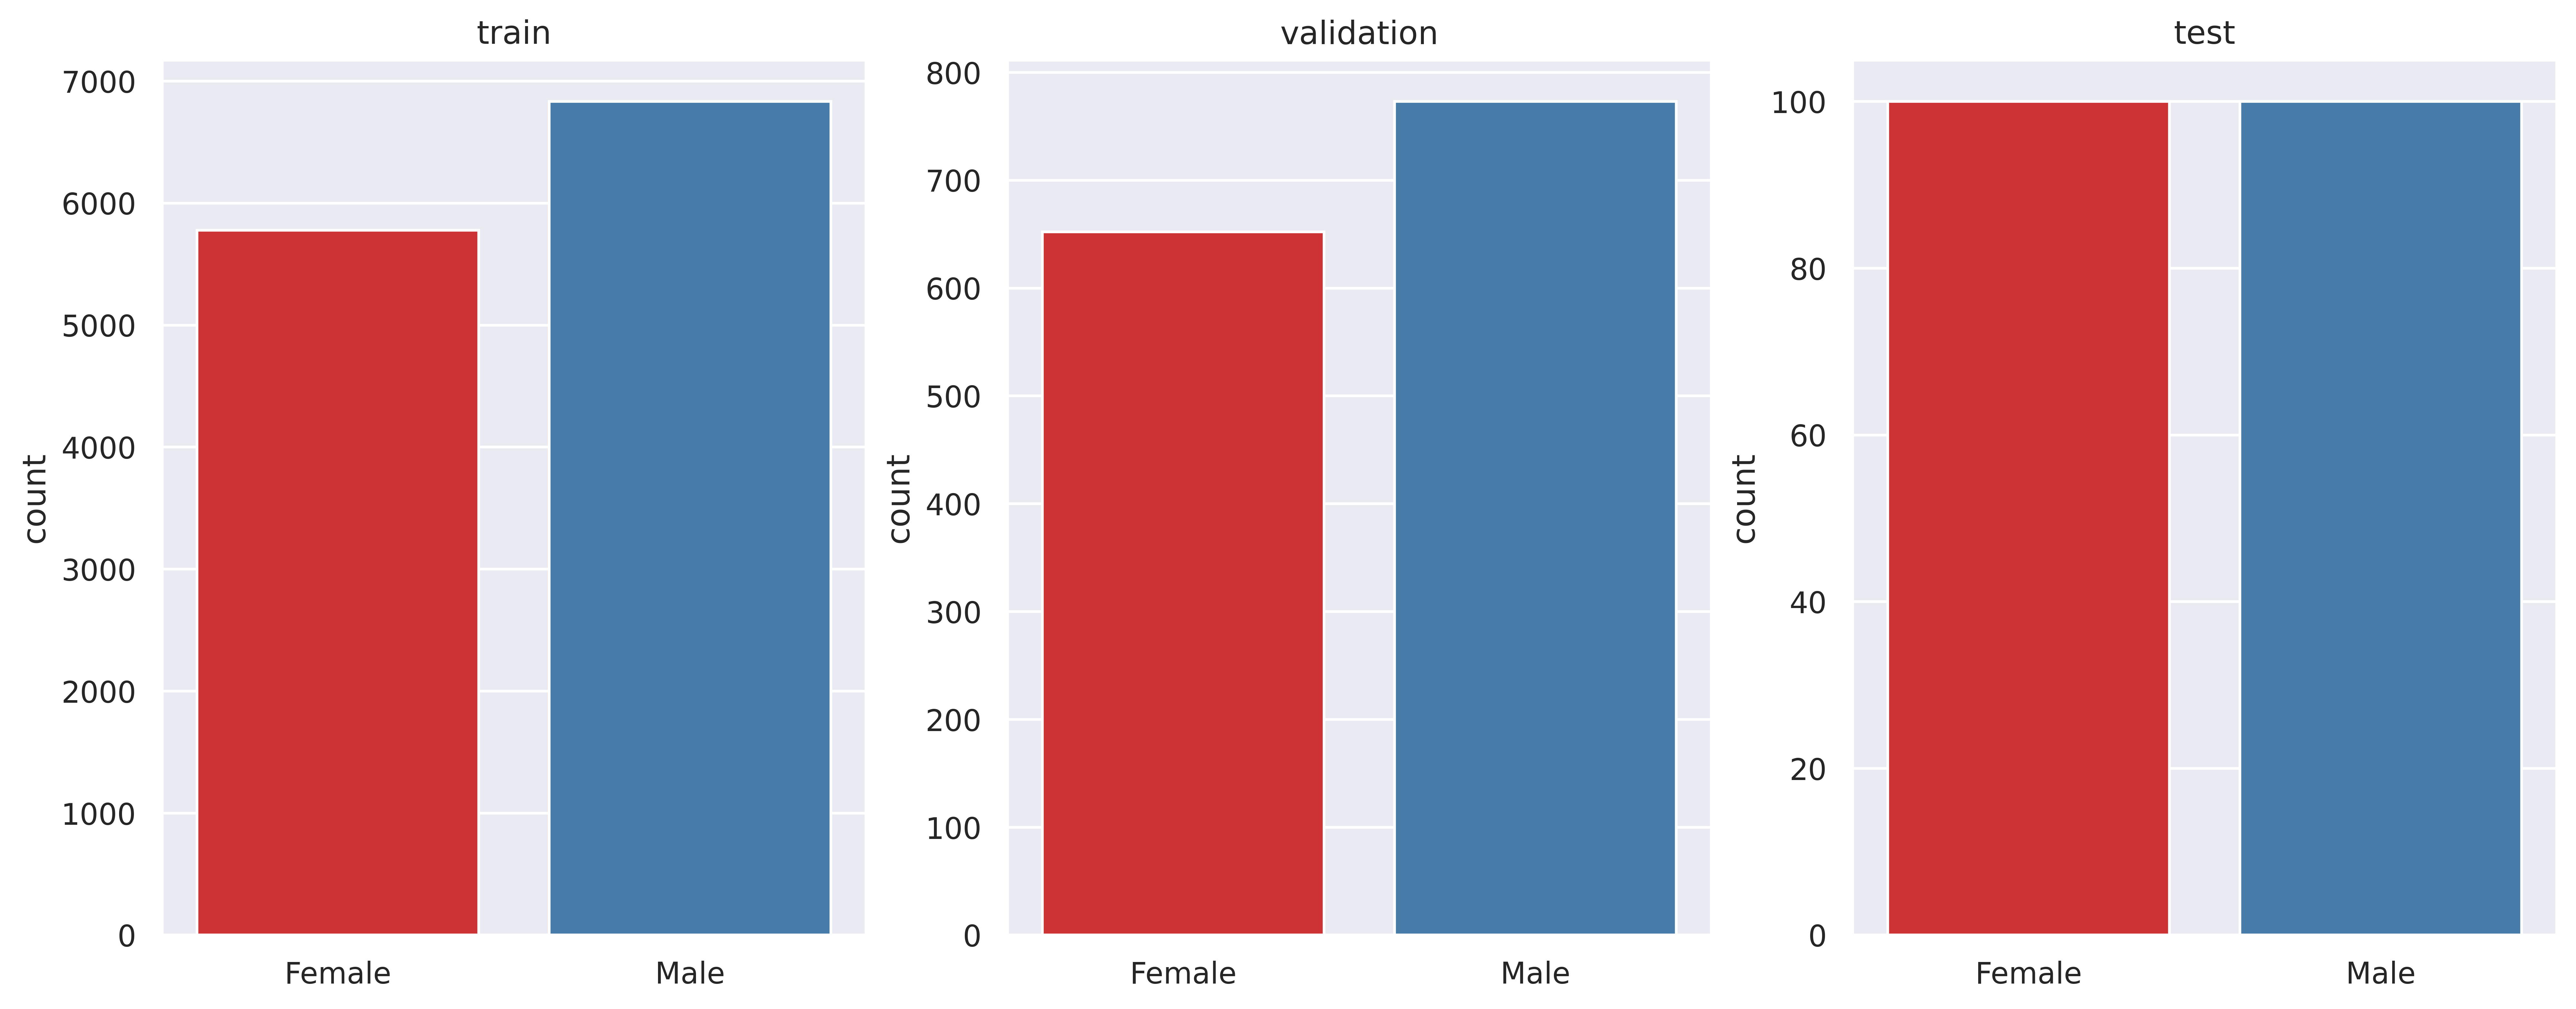

In [ ]:
"""
Gender distribution in each dataset
"""
sns.set_theme(style = 'darkgrid',palette = 'Set1')
fig, ax = plt.subplots(1,3, figsize = (16,6), dpi = 600)

sns.countplot(train_df.gender_01, ax=ax[0]).set(title = 'train',xticklabels=['Female','Male'],xlabel = '')
sns.countplot(val_df.gender_01, ax=ax[1]).set(title = 'validation',xticklabels=['Female','Male'],xlabel = '')
sns.countplot(test_df.gender_01, ax=ax[2]).set(title = 'test', xticklabels=['Female','Male'],xlabel = '')
fig.show()

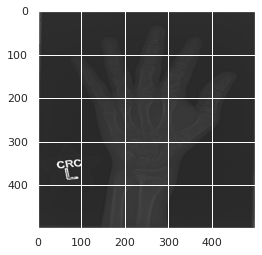

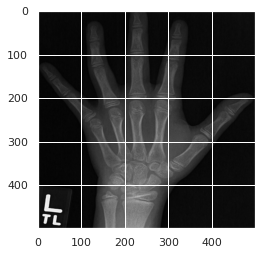

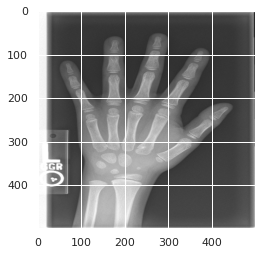

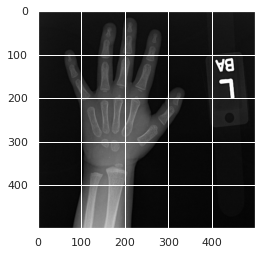

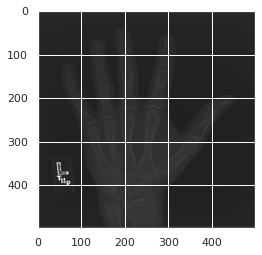

In [ ]:
"""
Visualizing some images:
"""
for img in train_df.id.sample(5):
    pic = cv2.imread('/content/train-dataset-compress/boneage-training-dataset/' + img)
    plt.imshow(pic)
    plt.show()

## Models

In [ ]:
"""
Model initialization:
"""
from scripts.my_models import create_EffNet, create_EffNet_noisy, create_InceptionRes, create_InceptionRes_v2, create_inception
EMBS = 1
IMG_SIZE = 456
# model = create_InceptionRes_v2(IMG_SIZE, embeddings = EMBS)
model = create_EffNet_noisy(IMG_SIZE, embeddings = EMBS, lr = 0.000001)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 456, 456, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 456, 456, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 456, 456, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 457, 457, 3)  0           normalization_2[0][0]            
____________________________________________________________________________________________

In [ ]:
"""
Creating the Pipeline:
"""
train_data_gen =  ImageDataGenerator(preprocessing_function = preprocess_input,rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, horizontal_flip = True, vertical_flip=True)
val_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

BATCH_SIZE = 10

train_input = myCustomGen(color='rgb' ,data_gen = train_data_gen, dff =  train_df, train = True, batch_size = BATCH_SIZE, img_size = IMG_SIZE, embeddings = EMBS)
val_input =  myCustomGen(color = 'rgb', data_gen = val_data_gen, dff =  val_df, train=False,batch_size = BATCH_SIZE, img_size = IMG_SIZE, embeddings = EMBS)

"""
Creating the callbacks
"""
my_callbacks = CreateCallbacks(ckp = 'noisy_efficientnetb5.h5', training_log='noisy_efficientnetb5.log')


In [ ]:
model.load_weights('noisy_efficientnetb5.h5')
# model = load_model('models/models_noisy_efficientnetb5.h5')

In [ ]:
"""
Training the model:
"""
train_step = len(train_df) // BATCH_SIZE 
val_step = len(val_df) // BATCH_SIZE
history = model.fit(train_input,
                           validation_data = val_input,
                           validation_steps = val_step,
                           epochs = 50, 
                           steps_per_epoch = train_step,
                           callbacks=my_callbacks)

Found 12611 validated image filenames.
Epoch 1/50
1261/1261 [==============================] - 1186s 917ms/step - loss: 6.9250 - root_mean_squared_error: 9.1595 - mean_absolute_error: 6.8756 - val_loss: 6.3058 - val_root_mean_squared_error: 8.4697 - val_mean_absolute_error: 6.2564
Epoch 2/50
1261/1261 [==============================] - 1128s 895ms/step - loss: 6.8964 - root_mean_squared_error: 8.9537 - mean_absolute_error: 6.8469 - val_loss: 6.2903 - val_root_mean_squared_error: 8.4523 - val_mean_absolute_error: 6.2408
Epoch 3/50
1261/1261 [==============================] - 1123s 891ms/step - loss: 6.8220 - root_mean_squared_error: 9.2220 - mean_absolute_error: 6.7725 - val_loss: 6.2997 - val_root_mean_squared_error: 8.4517 - val_mean_absolute_error: 6.2501
Epoch 4/50
1261/1261 [==============================] - 1093s 867ms/step - loss: 6.8015 - root_mean_squared_error: 8.8767 - mean_absolute_error: 6.7519 - val_loss: 6.2884 - val_root_mean_squared_error: 8.4606 - val_mean_absolute_err

In [ ]:
"""
Saving the model:
"""
# model.save('models/models_noisy_efficientnetb5.h5')

In [ ]:
"""
Models evaluation: noisy efficient net b5 with -1 1 embeddings 
"""
test_df['gender_01'] = test_df.gender_01.replace(0,-1) 
preds_noisynetb5 = get_predictions(model = model,test_df = test_df,preprocess = True,embeddings = 1, iters = 10,width_shift_range = 0.25,height_shift_range=0.25)


Iteration: 0
Found 200 validated image filenames.
10/10 [==============================] - 9s 963ms/step
Iteration: 1
Found 200 validated image filenames.
10/10 [==============================] - 9s 967ms/step
Iteration: 2
Found 200 validated image filenames.
10/10 [==============================] - 9s 952ms/step
Iteration: 3
Found 200 validated image filenames.
10/10 [==============================] - 9s 950ms/step
Iteration: 4
Found 200 validated image filenames.
10/10 [==============================] - 9s 972ms/step
Iteration: 5
Found 200 validated image filenames.
10/10 [==============================] - 9s 944ms/step
Iteration: 6
Found 200 validated image filenames.
10/10 [==============================] - 9s 975ms/step
Iteration: 7
Found 200 validated image filenames.
10/10 [==============================] - 9s 950ms/step
Iteration: 8
Found 200 validated image filenames.
10/10 [==============================] - 9s 960ms/step
Iteration: 9
Found 200 validated image filenames.
10/10

In [ ]:
print('Predicions for this model (mean between the iters): {}'.format(MAE(preds_noisynetb5.mean(axis=1),test_df.boneage)))
print('Predicions for this model (median between the iters): {}'.format(MAE(preds_noisynetb5.median(axis=1),test_df.boneage)))

Predicions for this model (mean between the iters): 3.997820710861846
Predicions for this model (median between the iters): 3.983999336871847


In [ ]:
preds_noisynetb5.to_csv('predictions/noisynetb5.csv')

In [ ]:
"""
Models evaluation: InceptionResNetV2 with -1 1 embeddings 
"""
test_df['gender_01'] = test_df.gender_01.replace(0,-1) 
preds_inceptionResNetV2_new_emb = get_predictions(model = model,test_df = test_df,preprocess = True,embeddings = 1, iters = 10,width_shift_range = 0.25,height_shift_range=0.25)


Iteration: 0
Found 200 validated image filenames.
10/10 [==============================] - 12s 941ms/step
Iteration: 1
Found 200 validated image filenames.
10/10 [==============================] - 9s 940ms/step
Iteration: 2
Found 200 validated image filenames.
10/10 [==============================] - 9s 947ms/step
Iteration: 3
Found 200 validated image filenames.
10/10 [==============================] - 8s 936ms/step
Iteration: 4
Found 200 validated image filenames.
10/10 [==============================] - 9s 942ms/step
Iteration: 5
Found 200 validated image filenames.
10/10 [==============================] - 9s 947ms/step
Iteration: 6
Found 200 validated image filenames.
10/10 [==============================] - 9s 950ms/step
Iteration: 7
Found 200 validated image filenames.
10/10 [==============================] - 8s 930ms/step
Iteration: 8
Found 200 validated image filenames.
10/10 [==============================] - 9s 950ms/step
Iteration: 9
Found 200 validated image filenames.
10/1

In [ ]:
print('Predicions for this model (mean between the iters): {}'.format(MAE(preds_inceptionResNetV2_new_emb.mean(axis=1),test_df.boneage)))
print('Predicions for this model (median between the iters): {}'.format(MAE(preds_inceptionResNetV2_new_emb.median(axis=1),test_df.boneage)))

Predicions for this model (mean between the iters): 4.921221266758508
Predicions for this model (median between the iters): 4.926622515431302


In [ ]:
"""
Remapping test_df to 0 1 for the other models:
"""
test_df['gender_01'] = test_df.gender_01.replace(-1,0) #we want that for the other models

In [ ]:
"""
Models evaluation: InceptionResNetV2 
"""
model = load_model('models/models_InceptionResNetV2_Dense32_1000x2.h5')
preds_inceptionResNetV2 = get_predictions(model = model,test_df = test_df,preprocess = True,embeddings = 1, iters = 10,width_shift_range = 0.25,height_shift_range=0.25)


Iteration: 0
Found 200 validated image filenames.
10/10 [==============================] - 12s 932ms/step
Iteration: 1
Found 200 validated image filenames.
10/10 [==============================] - 9s 956ms/step
Iteration: 2
Found 200 validated image filenames.
10/10 [==============================] - 9s 938ms/step
Iteration: 3
Found 200 validated image filenames.
10/10 [==============================] - 9s 950ms/step
Iteration: 4
Found 200 validated image filenames.
10/10 [==============================] - 9s 949ms/step
Iteration: 5
Found 200 validated image filenames.
10/10 [==============================] - 9s 945ms/step
Iteration: 6
Found 200 validated image filenames.
10/10 [==============================] - 8s 935ms/step
Iteration: 7
Found 200 validated image filenames.
10/10 [==============================] - 8s 928ms/step
Iteration: 8
Found 200 validated image filenames.
10/10 [==============================] - 9s 957ms/step
Iteration: 9
Found 200 validated image filenames.
10/1

In [ ]:
print('Predicions for this model (mean between the iters): {}'.format(MAE(preds_inceptionResNetV2.mean(axis=1),test_df.boneage)))
print('Predicions for this model (median between the iters): {}'.format(MAE(preds_inceptionResNetV2.median(axis=1),test_df.boneage)))

Predicions for this model (mean between the iters): 4.863813376190752
Predicions for this model (median between the iters): 4.884632062126934


In [ ]:
"""
Models evaluation: EfficientNetB4 
"""
model = load_model('models/models_EfficientNetB4_Dense32_1000x2.h5')
preds_EfficientNetB4 = get_predictions(model = model,test_df = test_df,preprocess = True,embeddings = 1, iters = 10,width_shift_range = 0.25,height_shift_range=0.25)


Iteration: 0
Found 200 validated image filenames.
10/10 [==============================] - 11s 919ms/step
Iteration: 1
Found 200 validated image filenames.
10/10 [==============================] - 8s 903ms/step
Iteration: 2
Found 200 validated image filenames.
10/10 [==============================] - 8s 932ms/step
Iteration: 3
Found 200 validated image filenames.
10/10 [==============================] - 8s 907ms/step
Iteration: 4
Found 200 validated image filenames.
10/10 [==============================] - 8s 921ms/step
Iteration: 5
Found 200 validated image filenames.
10/10 [==============================] - 8s 912ms/step
Iteration: 6
Found 200 validated image filenames.
10/10 [==============================] - 8s 911ms/step
Iteration: 7
Found 200 validated image filenames.
10/10 [==============================] - 8s 926ms/step
Iteration: 8
Found 200 validated image filenames.
10/10 [==============================] - 8s 931ms/step
Iteration: 9
Found 200 validated image filenames.
10/1

In [ ]:
print('Predicions for this model (mean between the iters): {}'.format(MAE(preds_EfficientNetB4.mean(axis=1),test_df.boneage)))
print('Predicions for this model (median between the iters): {}'.format(MAE(preds_EfficientNetB4.median(axis=1),test_df.boneage)))

Predicions for this model (mean between the iters): 5.232893454945161
Predicions for this model (median between the iters): 5.17416425382616


In [ ]:
"""
Models evaluation: EfficientNetB7 
"""
model = load_model('models/models_EfficientNetB7_Dense32_1000x2.h5')
preds_EfficientNetB7 = get_predictions(model = model,test_df = test_df,preprocess = True,embeddings = 1, iters = 10,width_shift_range = 0.25,height_shift_range=0.25)


Iteration: 0
Found 200 validated image filenames.
10/10 [==============================] - 14s 994ms/step
Iteration: 1
Found 200 validated image filenames.
10/10 [==============================] - 9s 1s/step
Iteration: 2
Found 200 validated image filenames.
10/10 [==============================] - 9s 988ms/step
Iteration: 3
Found 200 validated image filenames.
10/10 [==============================] - 9s 991ms/step
Iteration: 4
Found 200 validated image filenames.
10/10 [==============================] - 9s 1s/step
Iteration: 5
Found 200 validated image filenames.
10/10 [==============================] - 9s 999ms/step
Iteration: 6
Found 200 validated image filenames.
10/10 [==============================] - 9s 999ms/step
Iteration: 7
Found 200 validated image filenames.
10/10 [==============================] - 9s 1s/step
Iteration: 8
Found 200 validated image filenames.
10/10 [==============================] - 9s 1s/step
Iteration: 9
Found 200 validated image filenames.
10/10 [=========

In [ ]:
print('Predicions for this model (mean between the iters): {}'.format(MAE(preds_EfficientNetB7.mean(axis=1),test_df.boneage)))
print('Predicions for this model (median between the iters): {}'.format(MAE(preds_EfficientNetB7.median(axis=1),test_df.boneage)))

Predicions for this model (mean between the iters): 6.3822361685793885
Predicions for this model (median between the iters): 6.377875990981923


In [ ]:
"""
Models evaluation: InceptionResNetV2 with 10 embeddings 
"""
model = load_model('models/models_InceptionResNetV2_10_1000x2.h5')
preds_InceptionResNetV2_10 = get_predictions(model = model,test_df = test_df,preprocess = True,embeddings = 10, iters = 10,width_shift_range = 0.25,height_shift_range=0.25)


Iteration: 0
Found 200 validated image filenames.
10/10 [==============================] - 12s 947ms/step
Iteration: 1
Found 200 validated image filenames.
10/10 [==============================] - 9s 944ms/step
Iteration: 2
Found 200 validated image filenames.
10/10 [==============================] - 9s 951ms/step
Iteration: 3
Found 200 validated image filenames.
10/10 [==============================] - 9s 939ms/step
Iteration: 4
Found 200 validated image filenames.
10/10 [==============================] - 9s 953ms/step
Iteration: 5
Found 200 validated image filenames.
10/10 [==============================] - 9s 938ms/step
Iteration: 6
Found 200 validated image filenames.
10/10 [==============================] - 9s 955ms/step
Iteration: 7
Found 200 validated image filenames.
10/10 [==============================] - 9s 945ms/step
Iteration: 8
Found 200 validated image filenames.
10/10 [==============================] - 9s 938ms/step
Iteration: 9
Found 200 validated image filenames.
10/1

In [ ]:
print('Predicions for this model (mean between the iters): {}'.format(MAE(preds_InceptionResNetV2_10.mean(axis=1),test_df.boneage)))
print('Predicions for this model (median between the iters): {}'.format(MAE(preds_InceptionResNetV2_10.median(axis=1),test_df.boneage)))

Predicions for this model (mean between the iters): 5.8299275533779955
Predicions for this model (median between the iters): 5.857589727081302


In [ ]:
"""
Models evaluation: InceptionResNetV2 with patches 
"""
preds_InceptionResNetV2_patches = pd.read_csv('predictions/predictions_patches.csv')
preds_InceptionResNetV2_patches.columns = ['iter{}'.format(i) for i in range(10)]

In [ ]:
print('Predicions for this model (mean between the iters): {}'.format(MAE(preds_InceptionResNetV2_patches.mean(axis=1),test_df.boneage)))
print('Predicions for this model (median between the iters): {}'.format(MAE(preds_InceptionResNetV2_patches.median(axis=1),test_df.boneage)))

Predicions for this model (mean between the iters): 4.91162820802912
Predicions for this model (median between the iters): 4.916801864781469


In [ ]:
list_of_preds = [preds_inceptionResNetV2_new_emb,preds_inceptionResNetV2,preds_InceptionResNetV2_patches,preds_EfficientNetB4, preds_EfficientNetB7,preds_InceptionResNetV2_10]

all_preds = []
for pred in list_of_preds:
    all_preds.append(MAE(pred.mean(axis=1),test_df.boneage))
best_preds = pd.DataFrame(np.transpose(np.array(all_preds)),columns = ['MAE_mean'],index = ['preds_inceptionResNetV2_new_emb', 'InceptionResNetV2','InceptionResNetV2_patches','EfficientNetB4', 'EfficientNetB7','InceptionResNetV2_10'])

all_preds = []
for pred in list_of_preds:
    all_preds.append(MAE(pred.median(axis=1),test_df.boneage))

best_preds['MAE_median'] = all_preds

In [ ]:
best_preds

,MAE_mean,MAE_median
preds_inceptionResNetV2_new_emb,4.921221,4.926623
InceptionResNetV2,4.863813,4.884632
InceptionResNetV2_patches,4.911628,4.916802
EfficientNetB4,5.232893,5.174164
EfficientNetB7,6.382236,6.377876
InceptionResNetV2_10,5.829928,5.857590


In [ ]:
"""
Making inference over our 3 best models
"""
final_preds = []
preds = [preds_inceptionResNetV2_new_emb,preds_inceptionResNetV2,preds_InceptionResNetV2_patches]#,preds_EfficientNetB4]#, preds_EfficientNetB7,preds_InceptionResNetV2_10]

counter = 1
for row in np.arange(len(test_df)):
    this_preds = []
    for col in preds_EfficientNetB4.columns:
        for pred in preds:
            this_preds.append(pred[col].values[row])
    final_preds.append(np.median(this_preds))

print('Overall prediction MAE for our {} best models: {} months'.format(len(preds), np.mean(np.abs(final_preds - test_df.boneage))))

Overall prediction MAE for our 3 best models: 4.582357227537455 months


In [ ]:
test_df['predictions'] = final_preds
# test_df.to_csv('predictions/best_predictions.csv')
test_df =  pd.read_csv('predictions/best_predictions.csv')

### Some plots

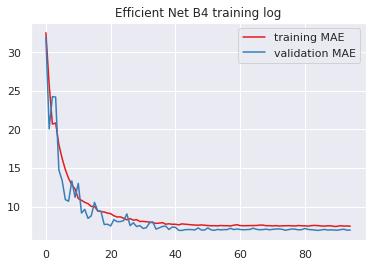

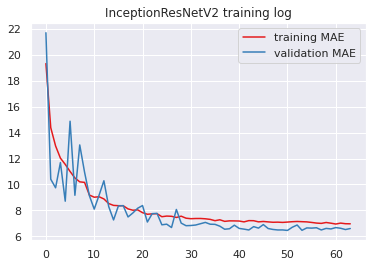

In [ ]:
"""
Training logs
"""
effnetb4_hist = pd.read_csv('histories/EfficientNetB4_Dense32_1000x2.log')
plt.plot(effnetb4_hist.mean_absolute_error, label = 'training MAE')
plt.plot(effnetb4_hist.val_mean_absolute_error, label = 'validation MAE')
plt.legend()
plt.title('Efficient Net B4 training log')
plt.show()

incresnetv2_hist = pd.read_csv('histories/InceptionResNetV2_Dense32_1000x2.log')
plt.plot(incresnetv2_hist.mean_absolute_error, label = 'training MAE')
plt.plot(incresnetv2_hist.val_mean_absolute_error, label = 'validation MAE')
plt.legend()
plt.title('InceptionResNetV2 training log')
plt.show()

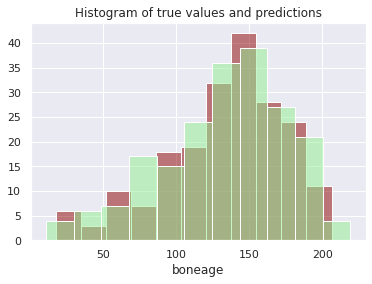

In [ ]:
"""
Histograms of predictions and true values
"""
sns.histplot(test_df.predictions,color='darkred',alpha = 0.5).set(xlabel = 'boneage',ylabel = '')
sns.histplot(test_df.boneage,color='lightgreen', alpha=0.5).set(xlabel = 'boneage',ylabel = '')
plt.title('Histogram of true values and predictions')
plt.show()


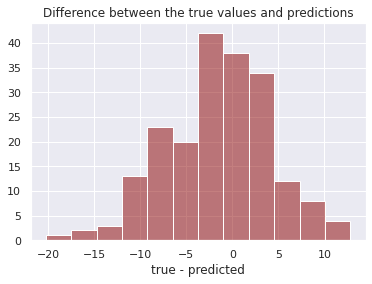

In [ ]:
"""
Histograms of the delta between predictions and true values
"""
sns.histplot(test_df.boneage - test_df.predictions,color='darkred', alpha=0.5).set(xlabel = 'true - predicted',ylabel = '')
plt.title('Difference between the true values and predictions')
plt.show()

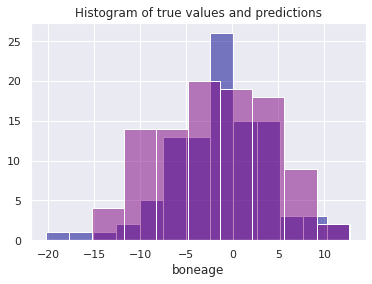

In [ ]:
"""
Histograms of the delata predictions and true values with gender separation
"""
sns.histplot(test_df[test_df.gender_01 == 1].boneage - test_df[test_df.gender_01 == 1].predictions,color='darkblue',alpha = 0.5).set(xlabel = 'males',ylabel = '')
sns.histplot(test_df[test_df.gender_01 == 0].boneage - test_df[test_df.gender_01 == 0].predictions,color='purple', alpha=0.5).set(xlabel = 'boneage',ylabel = '')
plt.title('Histogram of true values and predictions')
plt.show()

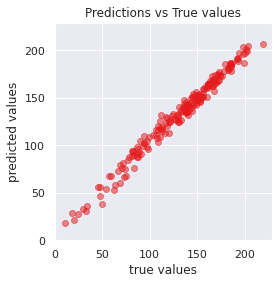

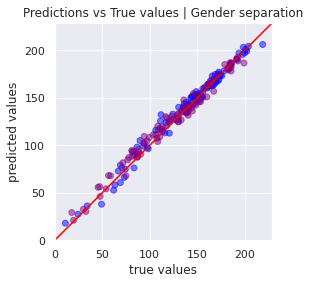

In [ ]:
"""
Scatter plot of predicted and true values
"""
import matplotlib.lines as mlines
plt.scatter(test_df.boneage,test_df.predictions,alpha = 0.5)
plt.xlim(0, 229)
plt.ylim(0, 229)
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.title('Predictions vs True values')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

fig, ax = plt.subplots()
colors = {0:'purple',1:'blue'}
ax.scatter(test_df.boneage,test_df.predictions, c = test_df.gender_01.apply(lambda x: colors[x]), alpha = 0.5)
plt.xlim(0, 229)
plt.ylim(0, 229)
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.title('Predictions vs True values | Gender separation')
x = np.linspace(0, 200, 1000)
ax.plot(x,x, color='red', transform=ax.transAxes)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
print('MAE for males: {} months'.format(MAE(test_df[test_df.gender_01 == 1].boneage , test_df[test_df.gender_01 == 1].predictions)))

MAE for males: 4.115500393720804 months


In [ ]:
print('MAE for females: {} months'.format(MAE(test_df[test_df.gender_01 == 0].boneage, test_df[test_df.gender_01 == 0].predictions)))

MAE for females: 5.141974321682131 months


In [ ]:
print('MAE for males: {} months'.format(MAE(test_df[test_df.gender_01 == 1].boneage , preds_inceptionResNetV2_new_emb.mean(axis=1)[:100])))

MAE for males: 4.902071735501684 months


In [ ]:
print('MAE for females: {} months'.format(MAE(test_df[test_df.gender_01 == 0].boneage , preds_inceptionResNetV2_new_emb.mean(axis=1)[100:])))

MAE for females: 4.940370798015326 months


In [ ]:
test_test = pd.read_csv('xdlmao.csv',sep = ',')

In [ ]:
print('MAE for males: {} months'.format(MAE(test_df[test_df.gender_01 == 1].boneage , test_test.predictions.values[:100])))

MAE for males: 4.715201058020628 months


In [ ]:
print('MAE for females: {} months'.format(MAE(test_df[test_df.gender_01 == 0].boneage , test_test.predictions.values[100:])))

MAE for females: 5.155132016842912 months


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6071f06e-2e8a-4273-b0c4-308d50da96ab' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>